In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from scipy import integrate
from helpers import Fy, find_closest_element, get_densities, get_cdf
import statsmodels.api as sm

In [3]:
# read in val data
B_zeta = np.load('../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/B_zeta_val.npy')
true_y = np.load('../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [4]:
# estimate density 
kde = sm.nonparametric.KDEUnivariate(true_y)
kde.fit()
support = kde.support
endog = kde.endog
density_gauss = kde.density

In [5]:
no_points = 16384
grid = support #np.linspace(min(density['axes']), max(density['axes']), no_points)
density_y = density['axes']
density_pdf = density['pdf']
# compute these beforehand to save computation time
p_y_y0 = [density_pdf[find_closest_element(y_i,density_y)] for y_i in grid]
part_1 = np.array([norm.ppf(Fy(y_i, density)) for y_i in grid])
phi_1_z = np.array([norm(0, 1).pdf(y_i) for y_i in part_1 ])

## True Density

In [6]:
grid = np.array([i for i in range(0, support.shape[0])])
def f_integral(i):
    return(integrate.trapz(density_gauss[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, grid)
cdf = np.cumsum(np.array(probs))

## VA + Horseshoe + Precise

In [9]:
va_horse_dir = '../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/'
mu_t_va = np.load(va_horse_dir + 'mu_ts2_new_dev.npy')
iteration = mu_t_va.shape[0]
p = 10
B_ts = np.mean(np.load(va_horse_dir + 'B_ts2_new_dev.npy')[int(0.9*iteration):,:,:], axis = 0)
d_ts = np.mean(np.load(va_horse_dir + 'd_ts2_new_dev.npy')[int(0.9*iteration):,:,:], axis = 0)
var = np.sqrt(np.diag(B_ts.dot(B_ts.T) + d_ts**2))

In [10]:
beta_va = np.mean(mu_t_va[int(0.9*iteration):,0:10], axis = 0)
Lambdas_log = np.mean(mu_t_va[int(0.9*iteration):,10:20], axis = 0)
samples = np.exp(0.5*np.random.multivariate_normal(Lambdas_log.reshape(10,), np.diag(var[10:20]), 10000))
Lambdas = np.mean(samples, axis = 0)

In [11]:
no_points = 16384
grid = np.linspace(min(density['axes']), max(density['axes']), no_points)
densities_va = get_densities(B_zeta, support, p_y_y0, part_1, phi_1_z, beta_va, None, p,  'va_horseshoe', Lambdas)

100%|██████████| 10472/10472 [01:25<00:00, 122.10it/s]


In [10]:
av_density_va = np.mean(np.array(densities_va), axis = 0)
def f_integral(i):
    return(integrate.trapz(av_density_va[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
cdf_va = np.cumsum(np.array(probs))

In [47]:
ridge_df = pd.read_csv('../../../../data/commaai/calibration/marginal_calibration/ridge_prior_calibration.csv')

No handles with labels found to put in legend.


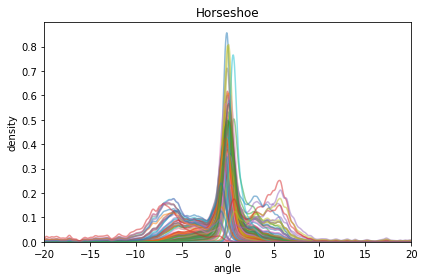

In [56]:
for dens in densities_va[0::100]:
    plt.plot(support, dens, alpha = 0.5)
plt.xlim(-20,20)
plt.ylim(0,)
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
plt.title('Horseshoe')
plt.tight_layout()
plt.savefig('random_dens_cpl_horse.png')

## HMC + Horseshoe + Precise

In [39]:
hmc_thetas = np.load('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy')

In [40]:
hmc_thetas[:,10:20] = np.exp(0.5*hmc_thetas[:,10:20])
hmc_thetas[:,20] = np.exp(hmc_thetas[:,20])

In [41]:
means = np.mean(hmc_thetas[1000:], axis = 0)

In [42]:
beta_hmc = means[0:10]
Lambda_hmc = hmc_thetas[1000:,10:20] 

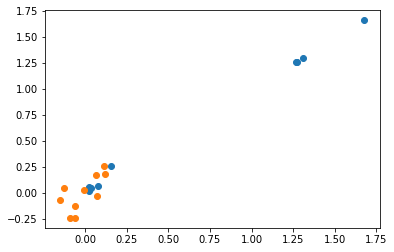

In [43]:
plt.scatter(Lambdas, np.mean(Lambda_hmc, axis = 0))
plt.scatter(beta_va, beta_hmc)

In [44]:
no_points = 16384
p = 10
densities_hmc = get_densities(B_zeta, support, p_y_y0, part_1, phi_1_z, beta_hmc, None, p,  'hmc_horseshoe', Lambda_hmc)

100%|██████████| 10472/10472 [24:38<00:00,  7.08it/s]


In [18]:
av_density_hmc = np.mean(np.array(densities_hmc), axis = 0)
def f_integral(i):
    return(integrate.trapz(av_density_hmc[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
cdf_horse_hmc = np.cumsum(np.array(probs))

In [57]:
len(densities_hmc[0::100])

105

No handles with labels found to put in legend.


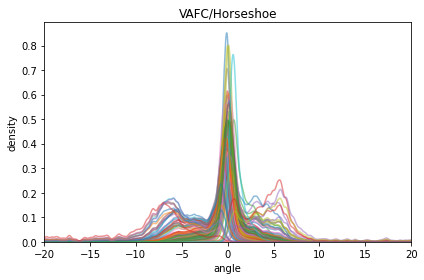

In [52]:
for dens in densities_hmc[0::100]:
    plt.plot(support, dens, alpha = 0.5)
plt.xlim(-20,20)
plt.ylim(0,)
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
plt.title('VAFC/Horseshoe')
plt.tight_layout()
plt.savefig('random_dens_cpl_horse_hmc.png')

## Marginal Calibration

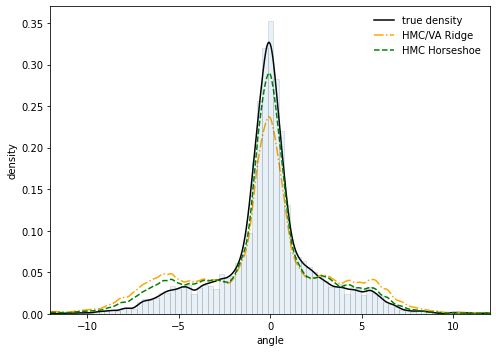

In [19]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.plot(support, density_gauss, color = 'black', label = 'true density')
ax.hist(true_y, bins=300, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.plot(ridge_df['support'], ridge_df['density_hmc'], color = 'orange', label = 'HMC/VA Ridge', linestyle = '-.')
#ax.plot(support, av_density_va, color = 'red', linestyle= '--', label = 'VA Horseshoe')
ax.plot(support, av_density_hmc, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.set_xlim(-12,12)
ax.legend()
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
plt.tight_layout()
plt.savefig('../../../data/commaai/calibration/marginal_calibration/marginal_calibration.png') 

## Probability Calibration

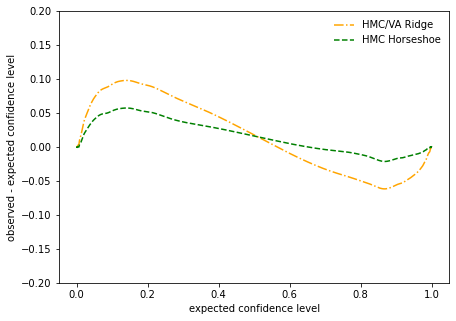

In [20]:
# plot like in Klein Paper
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
#ax.plot(cdf, cdf_va- cdf, color = 'red', label = 'VA/Horseshoe')
ax.plot(cdf, ridge_df['cdf_hmc'] - cdf, color = 'orange', label = 'HMC/VA Ridge', linestyle = '-.') #*0.9292
ax.plot(cdf, cdf_horse_hmc - cdf, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.legend()
plt.legend(framealpha=0.0)
#plt.tight_layout()
plt.autoscale()
plt.ylim(-.2,.2)
plt.xlabel('expected confidence level')
plt.ylabel('observed - expected confidence level')
plt.savefig('../../../data/commaai/calibration/marginal_calibration/prob_calibration.png') 

In [21]:
Gt = []
for i in tqdm(support):
    Gt.append(sum(x <= i for x in true_y))
Gt = np.array(Gt)/len(true_y)

100%|██████████| 16384/16384 [26:05<00:00, 10.46it/s]


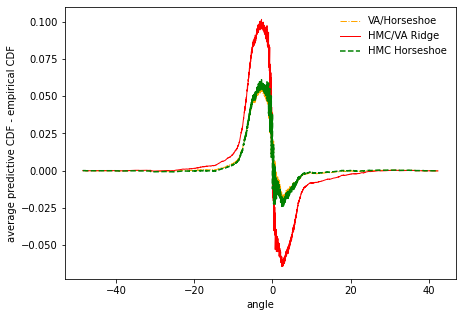

In [22]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(support, cdf_va - Gt,  color = 'orange', label = 'VA/Horseshoe', linestyle = '-.', linewidth = 1)
ax.plot(support, ridge_df['cdf_hmc'] - Gt, color = 'red', label = 'HMC/VA Ridge', linewidth = 1)
ax.plot(support, cdf_horse_hmc - Gt, color = 'green', linestyle= '--', label = 'HMC Horseshoe')
ax.legend()
plt.legend(framealpha=0.0)
#plt.tight_layout()
plt.xlabel('angle')
plt.autoscale()
plt.ylabel('average predictive CDF - empirical CDF')
plt.savefig('../../../data/commaai/calibration/marginal_calibration/marginal_calibration_2.png') 

## Probability Calibration PIT

In [23]:
cdf_va_is = []
j = 0
for supp in tqdm(densities_va):
    dens = densities_va[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], support[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1

100%|██████████| 10472/10472 [10:28:21<00:00,  3.60s/it]


In [24]:
cdf_hmc_is = []
j = 0
for supp in tqdm(densities_va):
    dens = densities_hmc[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], support[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_hmc_is.append(cdf_va_i)
    j += 1

100%|██████████| 10472/10472 [13:19:22<00:00,  4.58s/it] 


In [25]:
cdf_va_is = np.array(cdf_va_is)
cdf_hmc_is = np.array(cdf_hmc_is)

In [26]:
np.save('../../../data/commaai/calibration/marginal_calibration/cdf_va_horse_dens.npy', cdf_va_is)
np.save('../../../data/commaai/calibration/marginal_calibration/cdf_hmc_horse_dens.npy', cdf_hmc_is)

In [27]:
np.save('../../../data/commaai/calibration/marginal_calibration/support_va_horse_dens.npy', support)

In [ ]:
x = cdf_va_is[0]

In [ ]:
lb = max(x[x <= 0.025])
ub = min(x[x >= 0.975])

In [ ]:
alpha = 0.05
confidence_intervals = []
i = 0
for cdf in tqdm(cdf_va_is):
    lb = max(support[cdf <= alpha])
    try:
        ub = min(support[cdf >= 1-alpha/2])
    except: 
        print('error at index:' + str(i))
        ub = max(support)
    i += 1
    confidence_intervals.append([lb, ub])

In [ ]:
conf_width = np.array([confidence_intervals[i][1] - confidence_intervals[i][0] for i in range(0, len(cdf_va_is))])

In [ ]:
np.mean(conf_width)

In [ ]:
cdf_va_is.shape

In [ ]:
in_interval = []
for i in range(0, len(cdf_va_is)):
    conf_int = confidence_intervals[i]
    if conf_int[0] <= true_y[i] <= conf_int[1]:
        in_interval.append(1)
    else:
        in_interval.append(0)

In [ ]:
np.mean(in_interval)

In [ ]:
plt.plot(confidence_intervals)
plt.plot(true_y)

In [ ]:
grid == support